# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import time
import copy
import math


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

callsog = {}
pairsog = {}
livesog = {}

globalt0 = dt.datetime.now()

In [2]:
%time callsog['mit'] = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
callsog['mit'].head()

CPU times: user 410 ms, sys: 49.3 ms, total: 460 ms
Wall time: 489 ms


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,307,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,450,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,328,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,454,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,400,0


In [3]:
%time pairsog['mit'] = pc.pairs(callsog['mit'])
%time livesog['mit'] = pc.lives_dictionary(callsog['mit'])

CPU times: user 35.2 ms, sys: 1.2 ms, total: 36.4 ms
Wall time: 35.9 ms
CPU times: user 173 ms, sys: 0 ns, total: 173 ms
Wall time: 173 ms


In [4]:
tmp1 = pc.allcalls("../ukdata/collected_dunbar_calls_v3_e26OK_sorted.csv", (3, 'call'), 1, 2, [6,7], '%d/%m/%y %H:%M', header=False, min_activity=1)
tmp1.head()

,ego,alter,time,uclock,aclock
0,C07814508939,C0020165636994,2008-02-07 16:18:00,339,0
1,C07814508939,C0020165636994,2008-02-07 17:11:00,339,0
2,C07814508939,C0020165636994,2008-02-20 15:39:00,352,13
3,C07792658311,C0021213487966,2008-02-27 17:01:00,359,0
4,C07792658311,C0021213487966,2008-02-27 17:55:00,359,0


In [5]:
# Temporary data, since I will create two cohorts out of these
tmp2 = pc.pairs(tmp1)
tmp3 = pc.lives_dictionary(tmp1)

rmalter = {}
for ego in tmp3.keys():
    rmalter[ego] = []
    for alter in tmp3[ego].keys():
        if tmp3[ego][alter]['t0'] < 180:
            rmalter[ego].append(alter)
            
for i in tmp1.index:
    ego = tmp1.at[i, 'ego']
    alter = tmp1.at[i, 'alter']
    if alter in rmalter[ego]:
        tmp1.at[i, 'rm'] = 1
    else:
        tmp1.at[i, 'rm'] = 0

callsog['uk1'] = tmp1.loc[tmp1['rm'] == 1]
callsog['uk1'].drop(columns=['rm'], inplace=True)
callsog['uk1'].reset_index(drop=True, inplace=True)

new = tmp1.loc[tmp1['rm'] == 0]
new = new.loc[new['uclock'] >= 180]
new['uclock'] -= 180
new.to_csv("tmp2.csv")
callsog['uk2'] = pc.allcalls("tmp2.csv", (), 'ego', 'alter', ['time'], '%Y-%m-%d %H:%M:%S')
callsog['uk2'].reset_index(drop=True, inplace=True)
os.system("rm tmp2.csv")

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0

In [6]:
# This appends three characters at the start of each ego's label, to separate those egos in uk1 with those in uk2
callsog['uk1']['ego'] = 'uk1' + callsog['uk1']['ego']
callsog['uk2']['ego'] = 'uk2' + callsog['uk2']['ego']

<ipython-input-6-dfadca2f8dc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  callsog['uk1']['ego'] = 'uk1' + callsog['uk1']['ego']


## Limit data

In order to make all pairs of ego-alters (in all three cohorts comparable, I will limit the amount of phone calls to be analized, using the following criteria:

1. Only consider phone calls made by egos 30 days or later than their first appeareance.
2. For each alter, its maximum value of $a$ will be 200 days. This makes $\max_{\ell} = 200$.
3. Remove all alters whose first appeareance was **after** $T - \max{a}$. This is to guarantee that every alter could potentially reach $\max{a}$.

### Remove first 30 days of activity for each ego

In [7]:
calls = {}
for c in callsog.keys():
    uno = callsog[c].groupby('ego')[['uclock']].min()
    dos = pd.DataFrame()
    for ego in callsog[c]['ego'].unique():
        df = callsog[c].loc[callsog[c]['ego'] == ego]
        minday = uno.loc[ego]['uclock'] + 30
        df1 = df.loc[df['uclock'] >= minday]
        dos = dos.append(df1).reset_index(drop=True)
    old = len(callsog[c])
    calls[c] = dos
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 19098 calls
uk1 lost 5733 calls
uk2 lost 1684 calls


### Make $a_{\max} = 200$

In [8]:
for c in calls.keys():
    old = len(calls[c])
    calls[c] = calls[c].loc[calls[c]['aclock'] <= 200]
    print(f'{c} lost {old - len(calls[c])} calls')

mit lost 24426 calls
uk1 lost 37748 calls
uk2 lost 3229 calls


### Remove all alters with $t(0) > T - a_{\max}$

In [9]:
for c in calls.keys():
    uno = pd.DataFrame()
    T = max(calls[c]['uclock'])
    for ego in calls[c]['ego'].unique():
        df = calls[c].loc[calls[c]['ego'] == ego]
        for alter in df['alter'].unique():
            df2 = df.loc[df['alter'] == alter]
            mint = min(df2['uclock'])
            if mint < (T - 200):
                df2.loc[:, 'aclock'] = df2['uclock'] - mint
                uno = uno.append(df2).reset_index(drop=True)
    old = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    calls[c] = uno
    new = len(calls[c].groupby(['ego', 'alter'])[['aclock']].count())
    print(f'{c} lost {old - new} pairs of ego-alter')

/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


mit lost 7649 pairs of ego-alter
uk1 lost 38 pairs of ego-alter
uk2 lost 1905 pairs of ego-alter


In [10]:
calls['all'] = pd.DataFrame()
for c in ['mit', 'uk1', 'uk2']:
    calls['all'] = calls['all'].append(calls[c]).reset_index(drop=True)

In [11]:
pairs = {}
lives = {}
for c in calls.keys():
    pairs[c] = pc.pairs(calls[c])
    lives[c] = pc.lives_dictionary(calls[c])

In [12]:
maxell = 0
for c in lives.keys():
    for ego in lives[c].keys():
        for alter in lives[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            if ell > maxell:
                maxell = ell
    print(f'{c} has max ell {maxell}')

mit has max ell 200
uk1 has max ell 200
uk2 has max ell 200
all has max ell 200


## Separate cores of different sizes

In [13]:
t0 = time.time()
cores = {}
for s in range(1, 8):
    cores[s] = {}
    for c in callsog.keys():
        cores[s][c] = {}
        for ego in callsog[c]['ego'].unique():
            df = callsog[c].loc[callsog[c]['ego'] == ego]
            thecore = list(df.groupby('alter')[['aclock']].max().sort_values(by='aclock').index)[-s:]
            cores[s][c][ego] = thecore
print(f'This block took {time.time() - t0}')

This block took 9.745311737060547


In [14]:
cores[3]['uk1']['uk1C07896556837']

['C01142662662', 'C07821100539', 'C01142307325']

In [15]:
cores[3]['uk2']['uk2C07896556837']

['C07876773709', 'C07935088311', 'C07814891967']

In [16]:
t0 = dt.datetime.now()

callsoc = {}
callsnc = {}

for s in range(1, 8):
    callsoc[s] = {}
    callsoc[s]['all'] = pd.DataFrame()
    callsnc[s] = {}
    callsnc[s]['all'] = pd.DataFrame()
    for c in ['mit', 'uk1', 'uk2']:
        df = calls[c]
        callsoc[s][c] = pd.DataFrame()
        callsnc[s][c] = pd.DataFrame()
        for ego in df['ego'].unique():
            df2 = df.loc[df['ego'] == ego]
            tmp = df2['alter'].isin(cores[s][c][ego])
            df3 = df2.loc[tmp]
            callsoc[s][c] = callsoc[s][c].append(df3).reset_index(drop=True)
            tmp = ~df2['alter'].isin(cores[s][c][ego])
            df4 = df2.loc[tmp]
            callsnc[s][c] = callsnc[s][c].append(df4).reset_index(drop=True)
        callsoc[s]['all'] = callsoc[s]['all'].append(callsoc[s][c]).reset_index(drop=True)
        callsnc[s]['all'] = callsnc[s]['all'].append(callsnc[s][c]).reset_index(drop=True)
        
print(f'This block took {dt.datetime.now() - t0}')

This block took 0:00:07.400598


In [17]:
for s in callsoc.keys():
    for c in callsoc[s].keys():
        df = callsoc[s][c]
        for ego in df['ego'].unique():
            df2 = df.loc[df['ego'] == ego]
            if len(df2['alter'].unique()) > s:
                print(s, c, ego)

In [18]:
livesnc = {}
livesoc = {}
for s in callsnc.keys():
    livesnc[s] = {}
    livesoc[s] = {}
    for c in callsnc[s].keys():
        livesnc[s][c] = pc.lives_dictionary(callsnc[s][c])
        livesoc[s][c] = pc.lives_dictionary(callsoc[s][c])

# $\langle \overline{f}\rangle$ as a function of $\alpha$

In [19]:
t0 = dt.datetime.now()
bplotnc = {}
bplotoc = {}
for s in callsnc.keys():
    dffnc = pc.get_f(callsnc[s]['all'], 'all', 10, 70)
    bnc = pc.get_b(dffnc, 'alpha')
    bplotnc[s] = pc.plot_g(bnc, 'alpha')
    dffoc = pc.get_f(callsoc[s]['all'], 'all', 10, 70)
    boc = pc.get_b(dffoc, 'alpha')
    bplotoc[s] = pc.plot_g(boc, 'alpha')
print(f'This block took {dt.datetime.now() - t0}')

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


This block took 0:02:51.737188


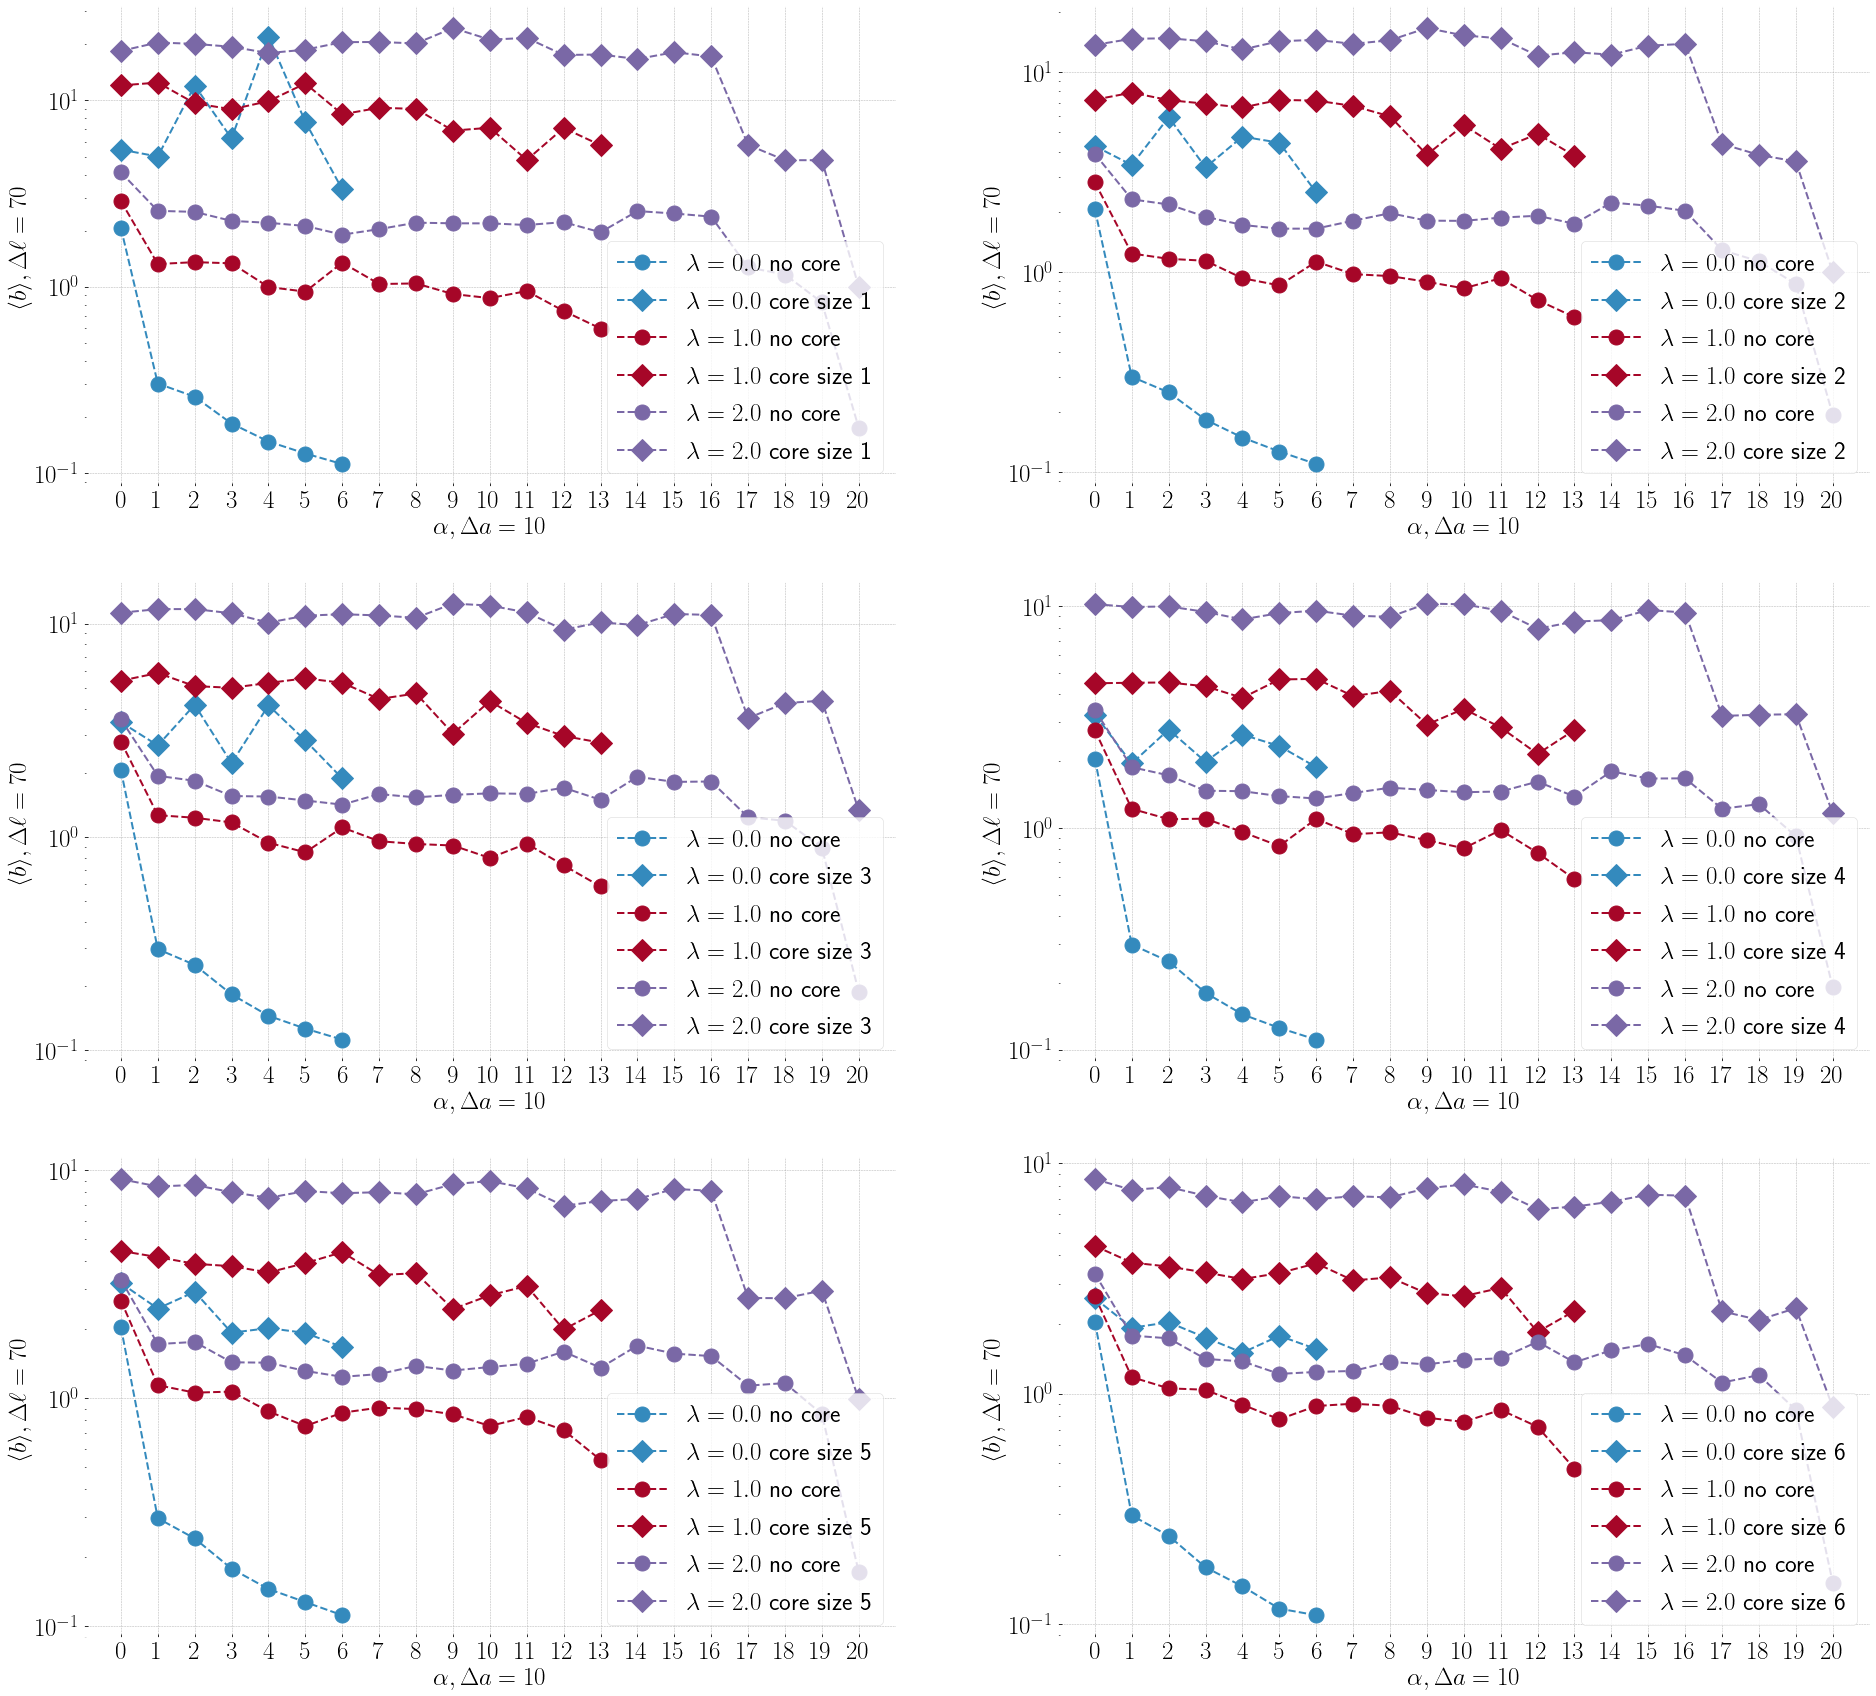

In [20]:
plt.figure(figsize=(32, 30))

for p in range(1, 7):
    plt.subplot(3,2,p)
    plt.ylabel(fr"$\langle b \rangle, \Delta \ell = 70$")
    plt.xlabel(r"$\alpha, \Delta a = 10$")
    plt.xticks(range(21))
    plt.yscale("log")
    for lamb in bplotnc[p].keys():
        plt.plot(bplotnc[p][int(lamb)].index, bplotnc[p][int(lamb)]['alpha'], marker="o", markersize=15, ls="--", c=colors[int(lamb)], label=fr'$\lambda = {lamb}$ no core')
        plt.plot(bplotoc[p][int(lamb)].index, bplotoc[p][int(lamb)]['alpha'], marker="D", markersize=15, ls="--", c=colors[int(lamb)], label=fr'$\lambda = {lamb}$ core size {p}')
    plt.legend()

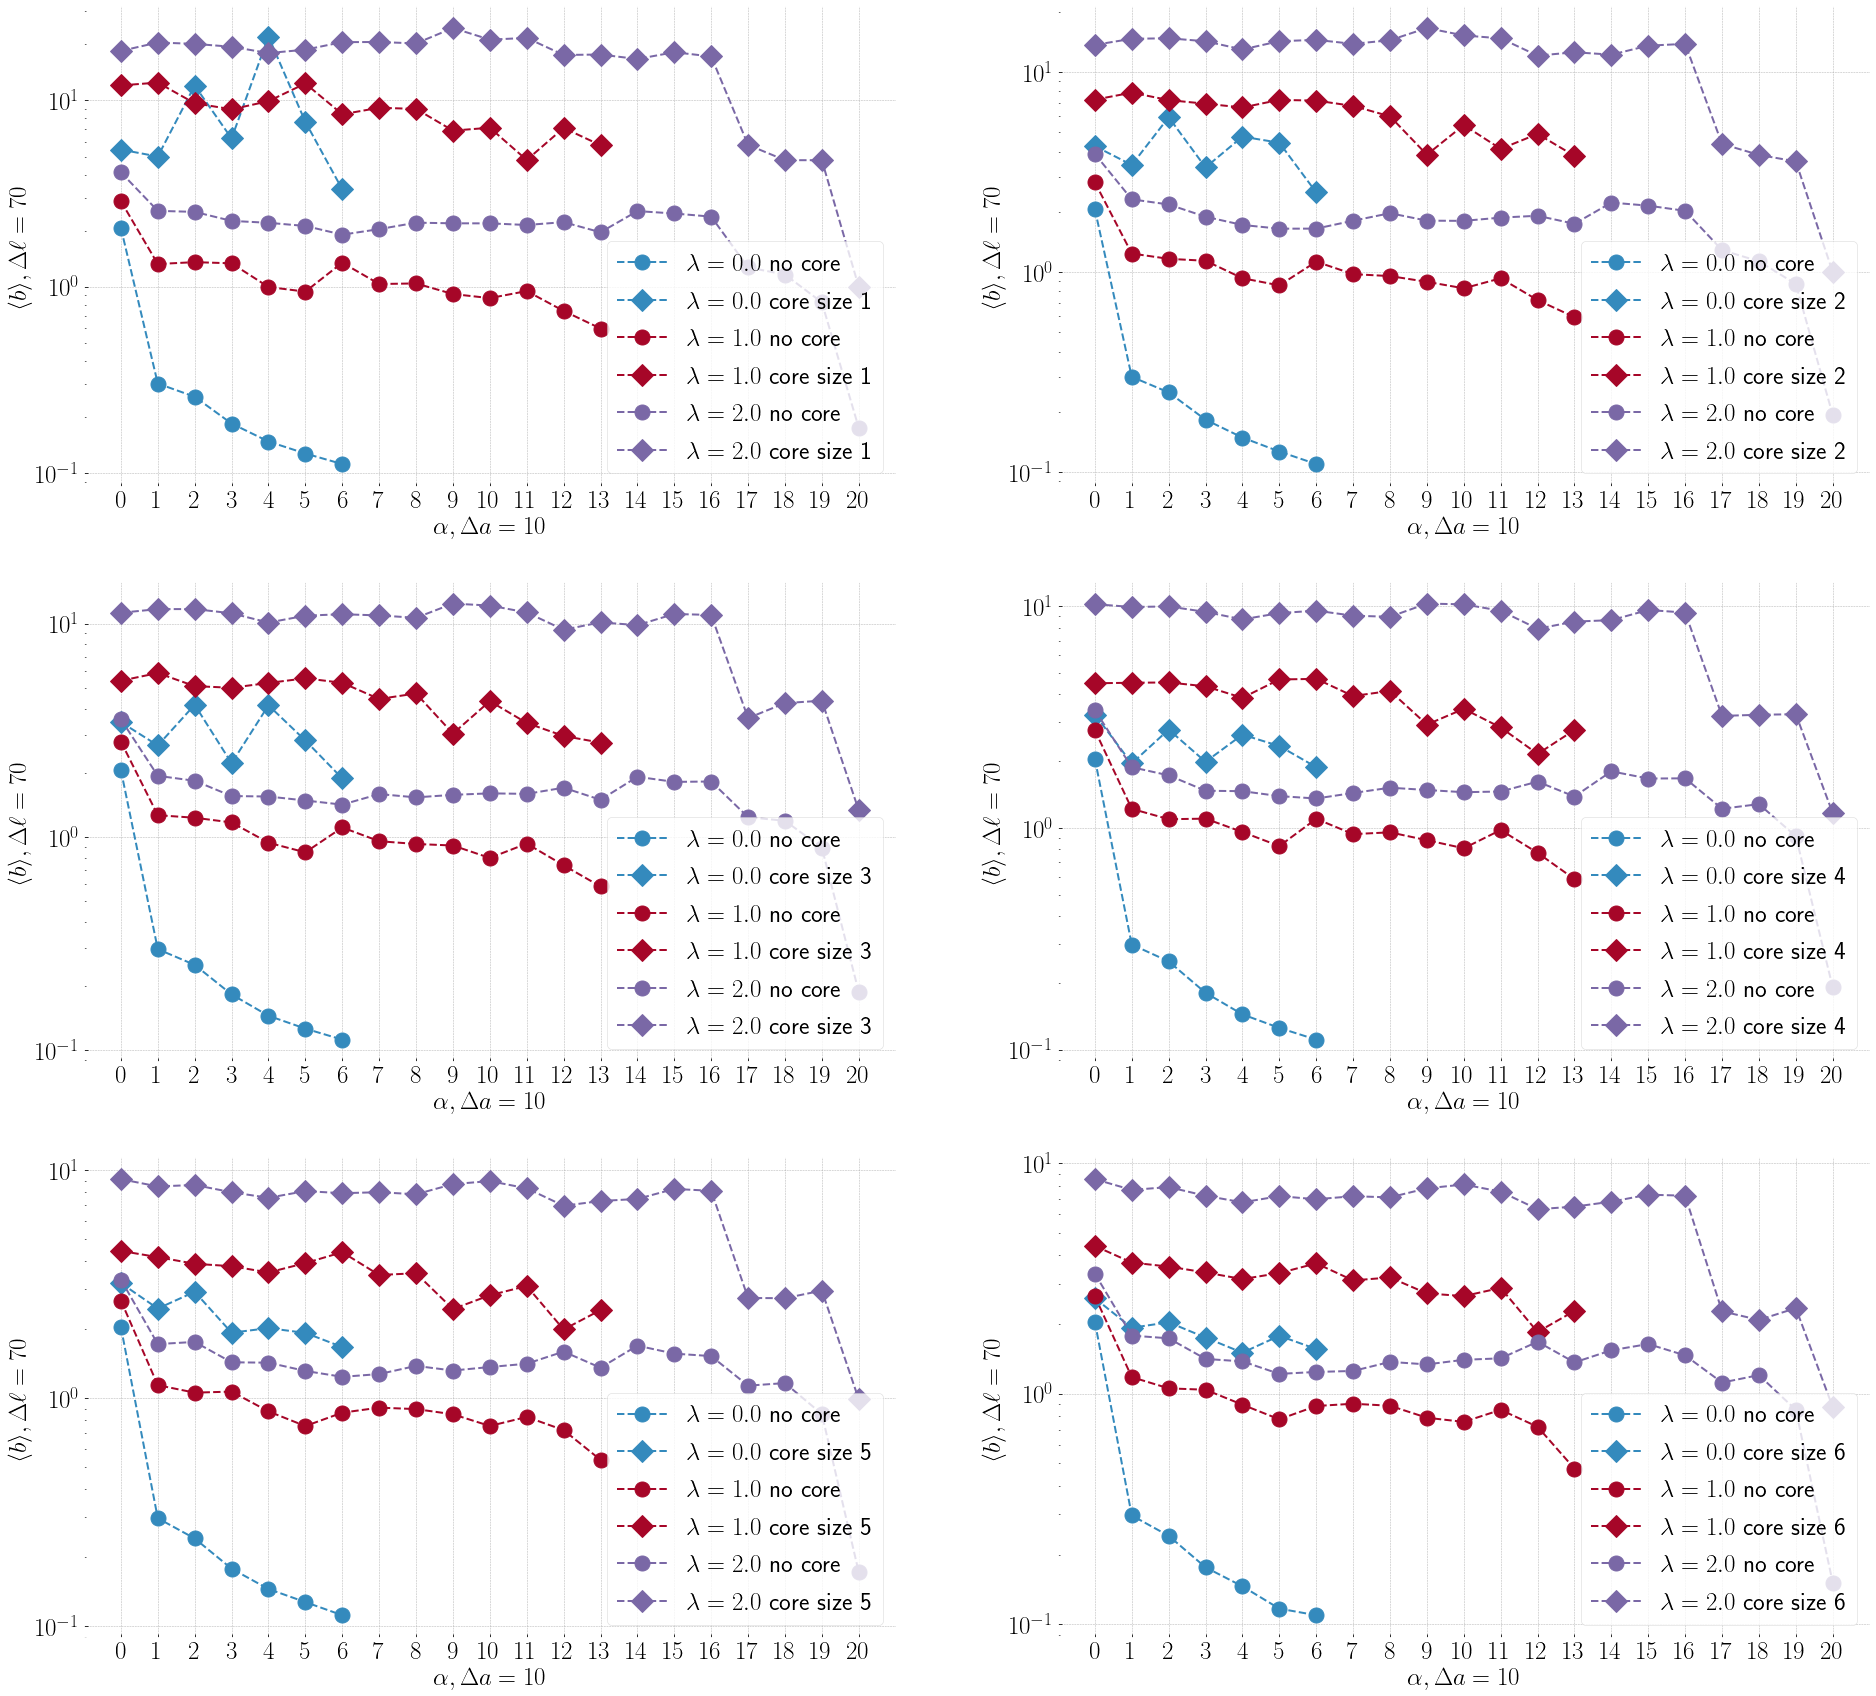

In [21]:
plt.figure(figsize=(32, 30))

for p in range(1, 7):
    plt.subplot(3,2,p)
    plt.ylabel(fr"$\langle b \rangle, \Delta \ell = 70$")
    plt.xlabel(r"$\alpha, \Delta a = 10$")
    plt.xticks(range(21))
    plt.yscale("log")
    for lamb in bplotnc[p].keys():
        plt.plot(bplotnc[p][int(lamb)].index, bplotnc[p][int(lamb)]['alpha'], marker="o", markersize=15, ls="--", c=colors[int(lamb)], label=fr'$\lambda = {lamb}$ no core')
        plt.plot(bplotoc[p][int(lamb)].index, bplotoc[p][int(lamb)]['alpha'], marker="D", markersize=15, ls="--", c=colors[int(lamb)], label=fr'$\lambda = {lamb}$ core size {p}')
    plt.legend()
#plt.savefig("../commpatterns/img/6cores.pdf", dpi=150)

# Time window does not matter

I will use a core of size 3

In [22]:
def get_survival(fresult, alphafixed=1, base=2, unbinned=False):
    tmp = {}
    for ego in fresult.keys():
        for alter in fresult[ego].keys():
            df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alphafixed]
            if len(df) > 0:
                if unbinned:
                    F = sum(df['f'])
                else:
                    F = int(math.log(sum(df['f']), base))
                tmp[F] = tmp.get(F, {})
                lamb = df.iloc[0]['lambda']
                tmp[F][lamb] = tmp[F].get(lamb, 0) + 1
    tmp2 = {}
    for F in sorted(tmp.keys()):
        df = pd.DataFrame.from_dict(tmp[F], orient='index').sort_index()
        tmp2[F] = {}
        df['p'] = df[0].div(sum(df[0]))
        for lc in range(21):
            df2 = df.loc[df.index >= lc]
            tmp2[F][lc] = round(sum(df2['p']), 6)
        tmp2[F] = pd.DataFrame.from_dict(tmp2[F], orient='index').sort_index()
    return tmp2

In [23]:
dff = pc.get_f(callsnc[3]['all'], 'all', 30, 10)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


In [24]:
test = {}
for ego in dff.keys():
    for alter in dff[ego].keys():
        data = dff[ego][alter].loc[dff[ego][alter]['alpha'] >= 1]
        if len(data) > 0:
            lamb = data.iloc[0]['lambda']
            test[lamb] = test.get(lamb, 0) + 1
test = pd.DataFrame.from_dict(test, orient='index').sort_index()
test['p'] = test[0] / sum(test[0])
null = {}
for lc in range(21):
    df = test.loc[test.index >= lc]
    null[lc] = sum(df['p'])
null = pd.DataFrame.from_dict(null, orient='index').sort_index()

In [25]:
survival = get_survival(dff)

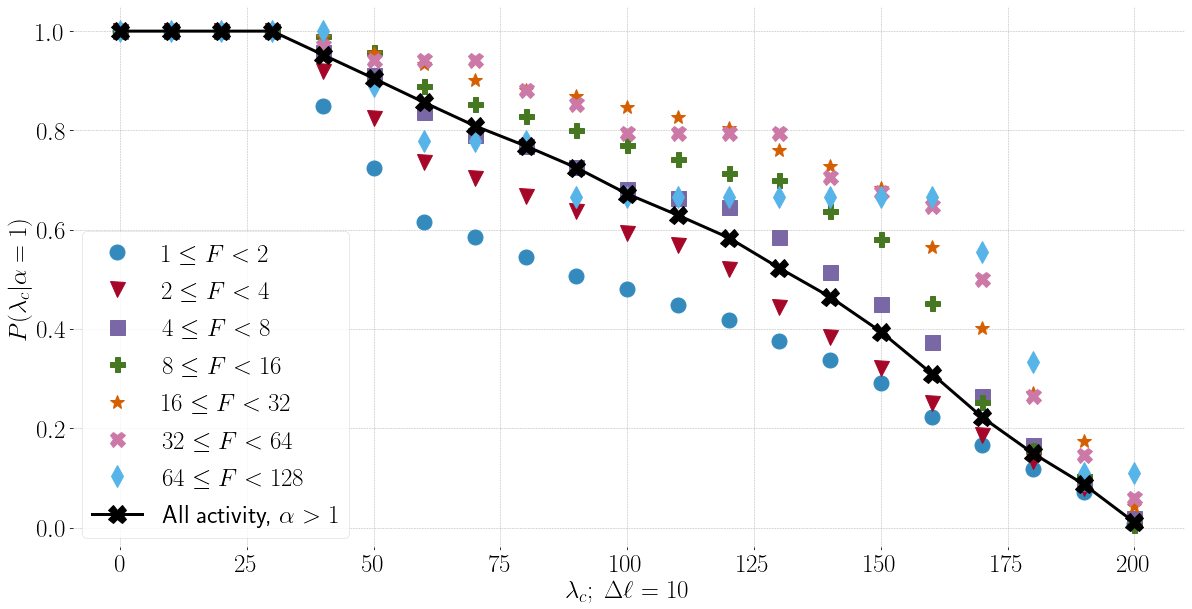

In [26]:
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(7)]

plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
m = 0
for f in range(7):
    plt.plot(survival[f].index * 10, survival[f][0], marker=markers[m], markersize=15, ls="", label=fr'{series2[f]}')
    m += 1
plt.plot(null.index * 10, null[0], marker="X", markersize=18, ls="-", lw=3, c="black", label=r"All activity, $\alpha > 1$")
plt.legend()

In [27]:
%time survival2 = get_survival(dff)

CPU times: user 2.46 s, sys: 41.1 ms, total: 2.51 s
Wall time: 2.36 s


In [28]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = survival[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/data/contour.dat", header=False, index=False, sep="\t")

In [29]:
# tmp = pd.DataFrame()
# for s in survival2.keys():
#     df = survival2[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/data/contour2.dat", header=False, index=False, sep="\t")

# Import the italian dataset

In [30]:
import pickle

with open('../itdata/mtl1_lambda_alpha_fig2.pickle', 'rb') as handle:
    it1 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl2_lambda_alpha_fig2.pickle', 'rb') as handle:
    it2 = pickle.load(handle)
    handle.close()

In [31]:
it1[37]['03af6295d75afd7593c3d9825197ce0a']

,lambda,alpha,f
0,15,0,12
1,15,1,4
2,15,2,5
3,15,3,3
4,15,4,6
5,15,5,3


In [32]:
t0 = dt.datetime.now()
dffit = {}
dffit['all'] = {}
data = [it1, it2]
dname = ['it1', 'it2']
for c in range(2):
    dffit[dname[c]] = {}
    for ego in data[c].keys():
        key = f'{dname[c]}{ego}'
        dffit[f'{dname[c]}'][key] = data[c][ego]
        dffit['all'][key] = data[c][ego]
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.000309


In [33]:
survivalit = {}
for c in dffit.keys():
    survivalit[c] = get_survival(dffit[c])

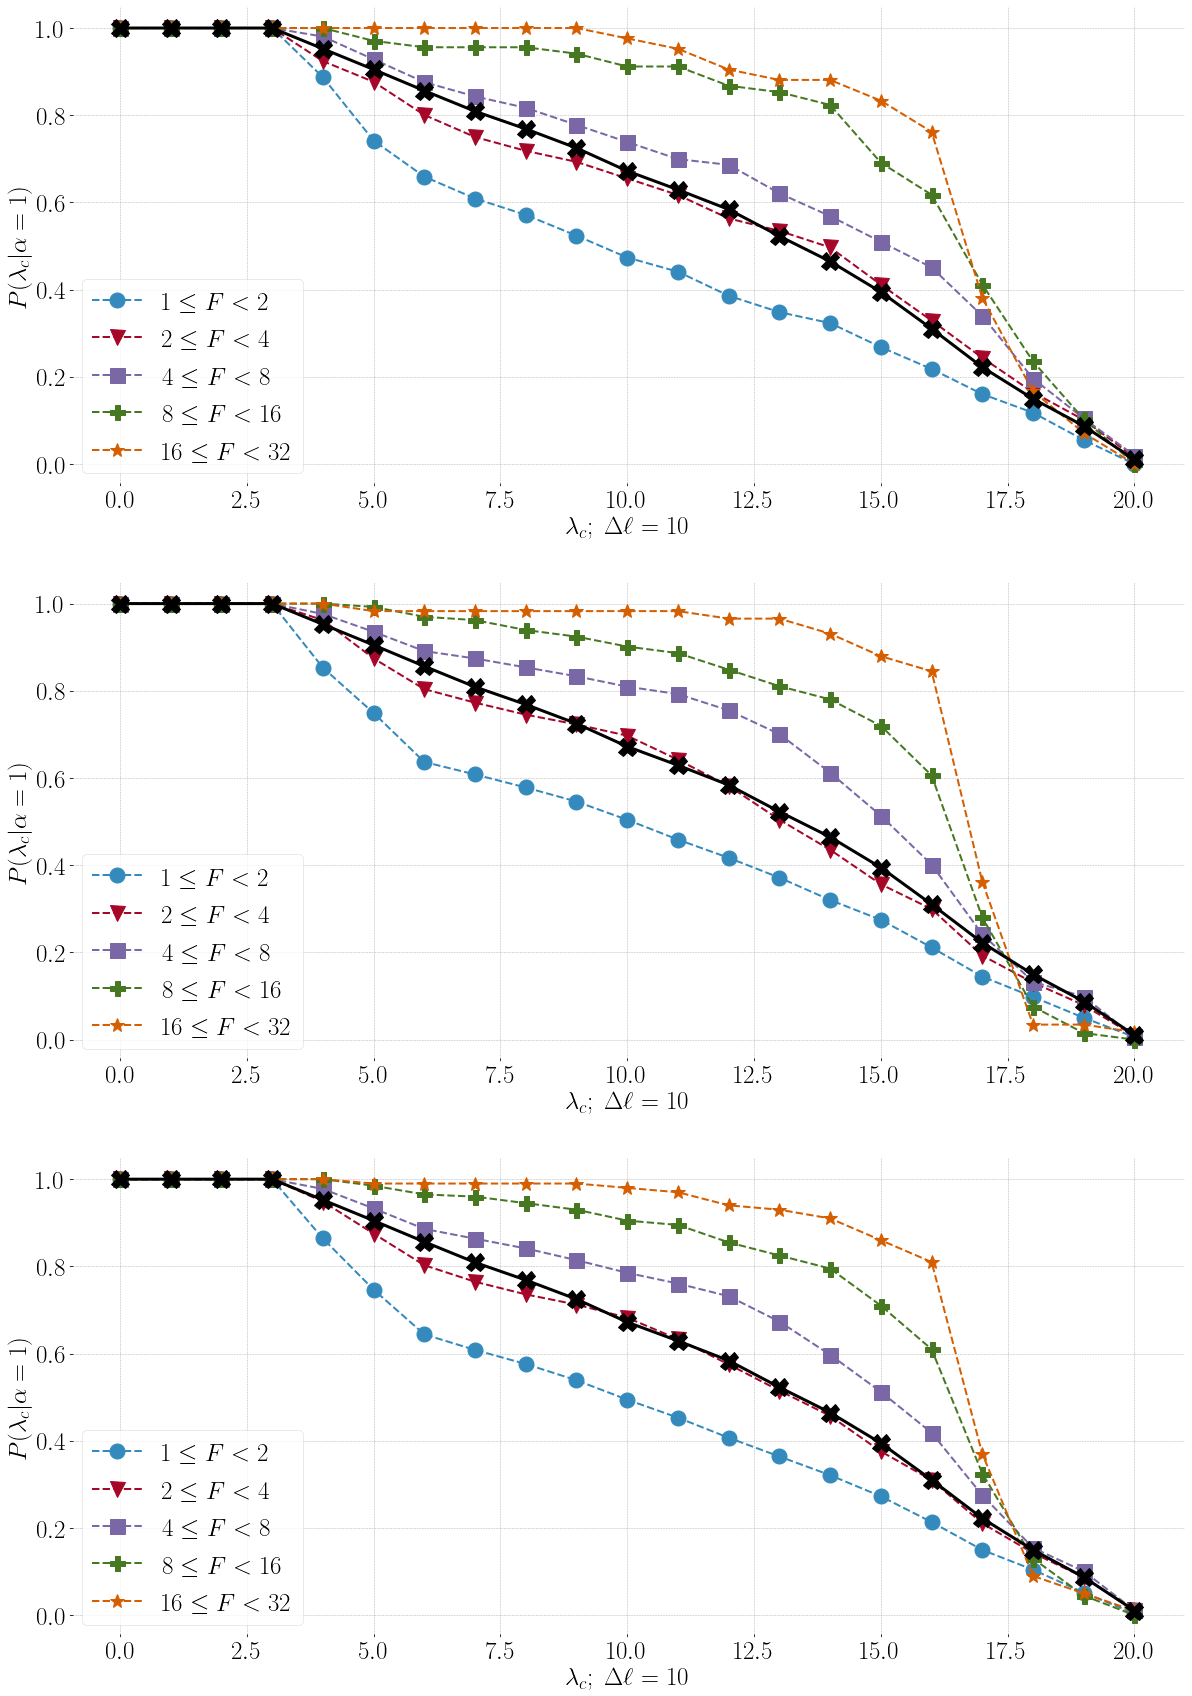

In [34]:
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(5)]
plt.figure(figsize=(20, 30))

plt.subplot(311)
plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
for F in range(5):
    plt.plot(survivalit['it1'][F].index, survivalit['it1'][F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
plt.plot(null.index, null[0], marker="X", markersize=18, ls="-", lw=3, c="black")
plt.legend()

plt.subplot(312)
plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
for F in range(5):
    plt.plot(survivalit['it2'][F].index, survivalit['it2'][F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
plt.plot(null.index, null[0], marker="X", markersize=18, ls="-", lw=3, c="black")
plt.legend()

plt.subplot(313)
plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
for F in range(5):
    plt.plot(survivalit['all'][F].index, survivalit['all'][F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
plt.plot(null.index, null[0], marker="X", markersize=18, ls="-", lw=3, c="black")
plt.legend()

In [35]:
# tmp = pd.DataFrame()
# for s in range(5):
#     df = survivalit['all'][s].reset_index()
#     df.columns = ['lc', 'p']
#     df['f'] = s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# sub = [(i/10, (i + 1)/10) for i in range(10)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df.drop(columns='z', inplace=True)
#     df.to_csv(f'../commpatterns/data/points{p}.dat', header=False, index=False, sep="\t")
#     p += 1

## Removing italian cores by looking at lives dictionaries

In [36]:
with open('../itdata/mtl1_lives.pickle', 'rb') as handle:
    dlit1 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl2_lives.pickle', 'rb') as handle:
    dlit2 = pickle.load(handle)
    handle.close()

In [37]:
livesit = {}
livesit['all'] = {}
names = ['it1', 'it2']
dicts = [dlit1, dlit2]
for c in range(2):
    livesit[names[c]] = {}
    for ego in dicts[c].keys():
        newkey = f'{names[c]}{ego}'
        livesit[names[c]][newkey] = dicts[c][ego]
        livesit['all'][newkey] = dicts[c][ego]

In [38]:
coresit = {}
for ego in livesit['all'].keys():
    tmp = {}
    for alter in livesit['all'][ego].keys():
        tmp[alter] = livesit['all'][ego][alter]['ell']
    tmp = pd.DataFrame.from_dict(tmp, orient='index').sort_values(by=0)
    coresit[ego] = list(tmp.index)[-3:]

In [39]:
t0 = dt.datetime.now()
dffitnc = {}
dffitoc = {}
for c in dffit.keys():
    dffitnc[c] = {}
    dffitoc[c] = {}
    for ego in dffit[c].keys():
        dffitnc[c][ego] = {}
        dffitoc[c][ego] = {}
        for alter in dffit[c][ego].keys():
            if alter in coresit[ego]:
                dffitoc[c][ego][alter] = dffit[c][ego][alter]
            else:
                dffitnc[c][ego][alter] = dffit[c][ego][alter]
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.009476


In [40]:
survivalitnc = {}
for c in dffitnc.keys():
    survivalitnc[c] = get_survival(dffitnc[c])

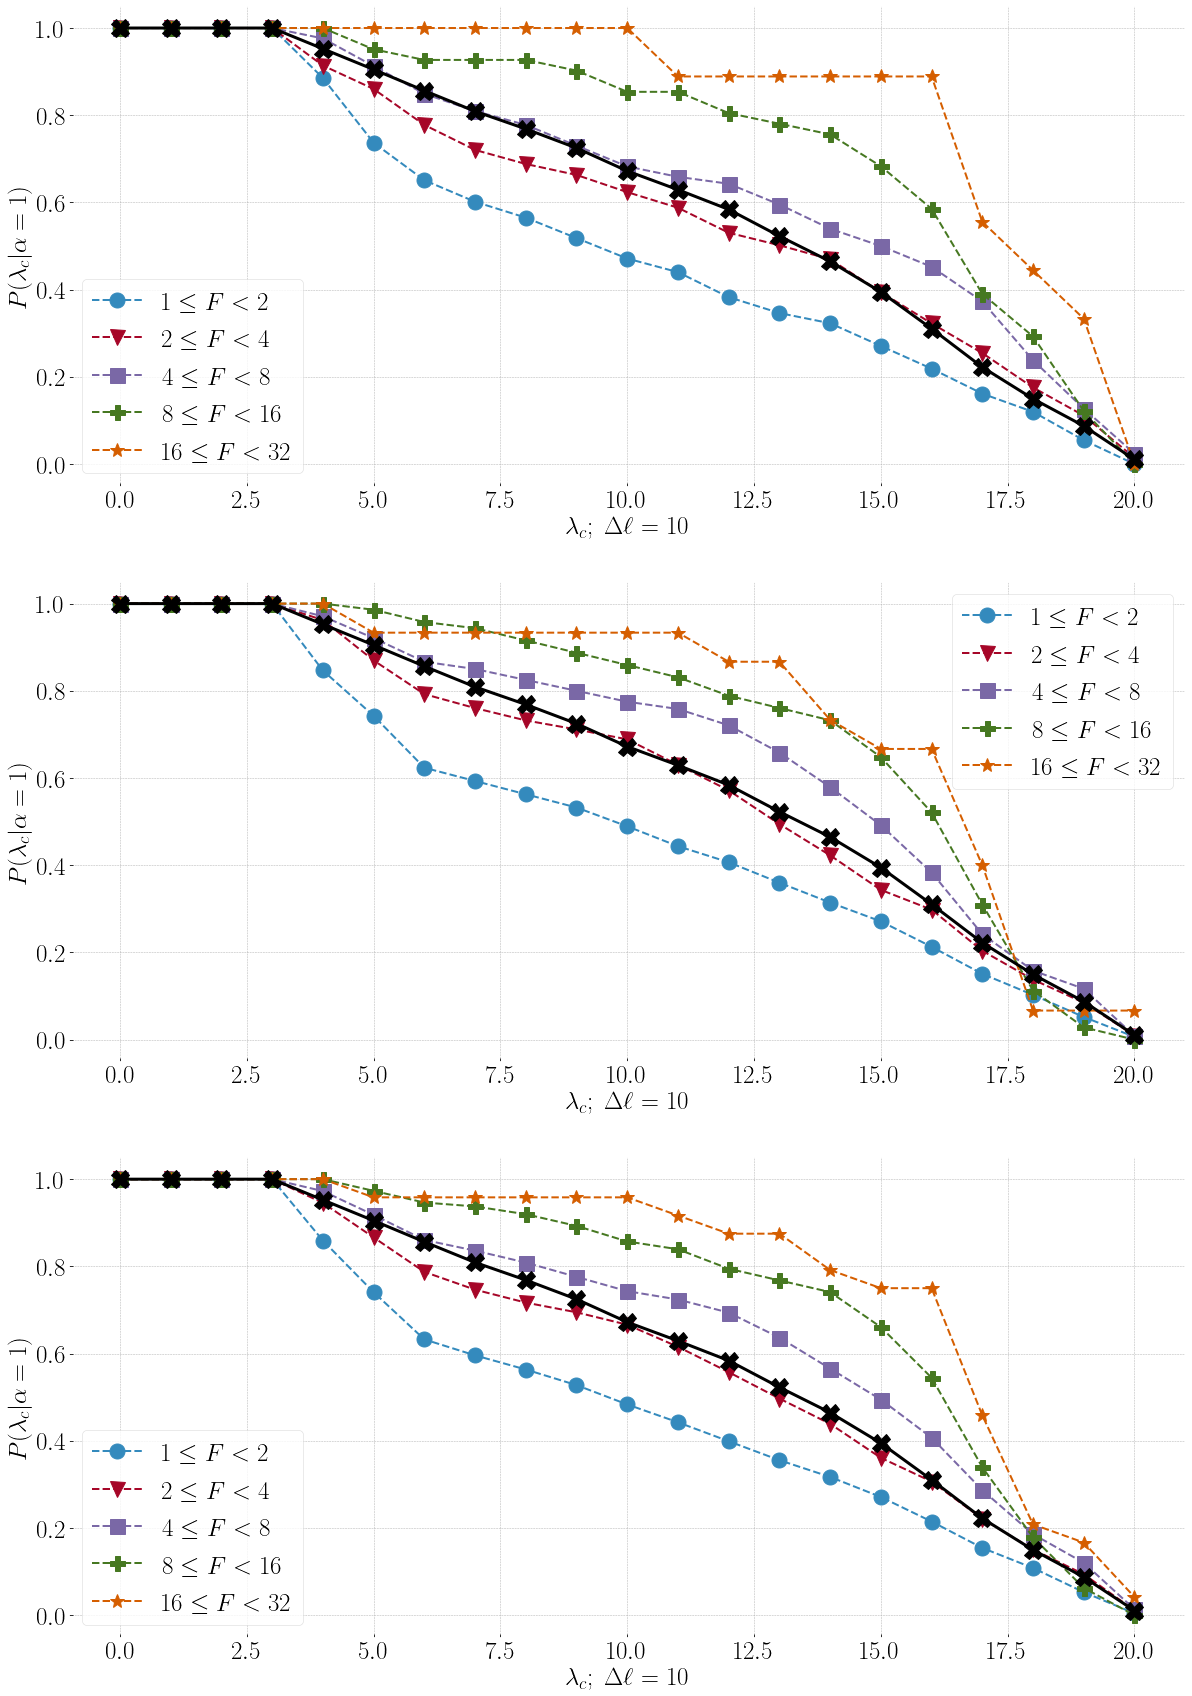

In [41]:
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(5)]
plt.figure(figsize=(20, 30))

plt.subplot(311)
plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
for F in range(5):
    plt.plot(survivalitnc['it1'][F].index, survivalitnc['it1'][F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
plt.plot(null.index, null[0], marker="X", markersize=18, ls="-", lw=3, c="black")
plt.legend()

plt.subplot(312)
plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
for F in range(5):
    plt.plot(survivalitnc['it2'][F].index, survivalitnc['it2'][F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
plt.plot(null.index, null[0], marker="X", markersize=18, ls="-", lw=3, c="black")
plt.legend()

plt.subplot(313)
plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
for F in range(5):
    plt.plot(survivalitnc['all'][F].index, survivalitnc['all'][F][0], marker=markers[F], markersize=15, ls="--", label=series2[F])
plt.plot(null.index, null[0], marker="X", markersize=18, ls="-", lw=3, c="black")
plt.legend()

In [42]:
survivalit2nc = get_survival(dffitnc[c], unbinned=True)

In [43]:
# tmp = pd.DataFrame()
# for s in range(5):
#     df = survivalitnc['all'][s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# sub = [(i/5, (i + 1)/5) for i in range(5)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df.drop(columns='z', inplace=True)
#     df.to_csv(f'../commpatterns/data/points{p}.dat', header=False, index=False, sep="\t")
#     p += 1

In [44]:
# tmp = pd.DataFrame()
# for s in survivalit2nc.keys():
#     if s <= 2**5 + 1:
#         df = survivalit2nc[s].reset_index()
#         df.columns = ['lc', 'p']
#         df['lc'] *= 10
#         df['f'] = s
#         ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#         tmp = tmp.append(ttmmpp).reset_index(drop=True)
# sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df.drop(columns='z', inplace=True)
#     df.to_csv(f'../commpatterns/data/points{p}.dat', header=False, index=False, sep="\t")
#     p += 1

## Update Figure 1 of the paper to include Italian data

In [45]:
t0 = dt.datetime.now()

with open('../itdata/mtl1_lambda_alpha_fig1.pickle', 'rb') as handle:
    it1 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl2_lambda_alpha_fig1.pickle', 'rb') as handle:
    it2 = pickle.load(handle)
    handle.close()
    

dffit2 = {}
dffit2['all'] = {}
data = [it1, it2]
dname = ['it1', 'it2']
for c in range(2):
    dffit2[dname[c]] = {}
    for ego in data[c].keys():
        key = f'{dname[c]}{ego}'
        dffit2[f'{dname[c]}'][key] = data[c][ego]
        dffit2['all'][key] = data[c][ego]
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:02.045736


In [46]:
t0 = dt.datetime.now()
dffit2nc = {}
dffit2oc = {}
for c in dffit2.keys():
    dffit2nc[c] = {}
    dffit2oc[c] = {}
    for ego in dffit2[c].keys():
        dffit2nc[c][ego] = {}
        dffit2oc[c][ego] = {}
        for alter in dffit2[c][ego].keys():
            if alter in coresit[ego]:
                dffit2oc[c][ego][alter] = dffit2[c][ego][alter]
            else:
                dffit2nc[c][ego][alter] = dffit2[c][ego][alter]
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.009299


In [47]:
def get_b(fresult, xaxis='alpha'):
    '''
    This is an alternative measurement to g. Instead of dividing the sum of f_i(lambda, alpha) by
    H(alpha), it does it by H(lambda). The arguments are:
    fresult             : dataframe produced with the get_f method
    xaxis               : this is for future plotting purposes. Which quantity should be
                        in the horizontal axis? Defaults to "alpha"

    The output is a dictionary with a dataframe per ego. Note that this is a variant of the g quantity,
    and therefore, the same method used to plot g can be applied here.
    '''
    g = {}
    r = {}
    for ego in fresult.keys():
        if len(fresult[ego].keys()) > 0:
            g[ego] = {}
            altl = {}
            for alter in fresult[ego].keys():
                l = list(fresult[ego][alter]['lambda'].unique())[0]
                altl[l] = altl.get(l, 0) + 1
            for alter in fresult[ego].keys():
                for i in fresult[ego][alter].index:
                    a = fresult[ego][alter].at[i, 'alpha']
                    l = fresult[ego][alter].at[i, 'lambda']
                    f = fresult[ego][alter].at[i, 'f']
                    if xaxis == 'lambda':
                        g[ego][a] = g[ego].get(a, {})
                        g[ego][a][l] = g[ego][a].get(l, 0) + f
                    elif xaxis == 'alpha':
                        g[ego][l] = g[ego].get(l, {})
                        g[ego][l][a] = g[ego][l].get(a, 0) + f

            idx = 0
            df = pd.DataFrame()
            for k in g[ego].keys():
                for kk in g[ego][k].keys():
                    if xaxis == 'lambda':
                        df.at[idx, 'lambda'] = kk
                        df.at[idx, 'alpha'] = k
                        df.at[idx, 'g'] = g[ego][k][kk] / altl[kk]
                        idx += 1
                    elif xaxis == 'alpha':
                        df.at[idx, 'lambda'] = k
                        df.at[idx, 'alpha'] = kk
                        df.at[idx, 'g'] = g[ego][k][kk] / altl[k]
                        idx += 1
            if xaxis == 'lambda':
                df.sort_values(by=['lambda', 'alpha'], inplace=True)
            elif xaxis == 'alpha':
                df.sort_values(by=['alpha', 'lambda'], inplace=True)
            df.reset_index(drop=True, inplace=True)
            r[ego] = df
    return r

In [48]:
t0 = dt.datetime.now()
bplotnc = {}
for c in dffit2nc.keys():
    bnc = get_b(dffit2nc[c], 'alpha')
    bplotnc[c] = pc.plot_g(bnc, 'alpha')
print(f'This block took {dt.datetime.now() - t0}')

This block took 0:00:08.570080


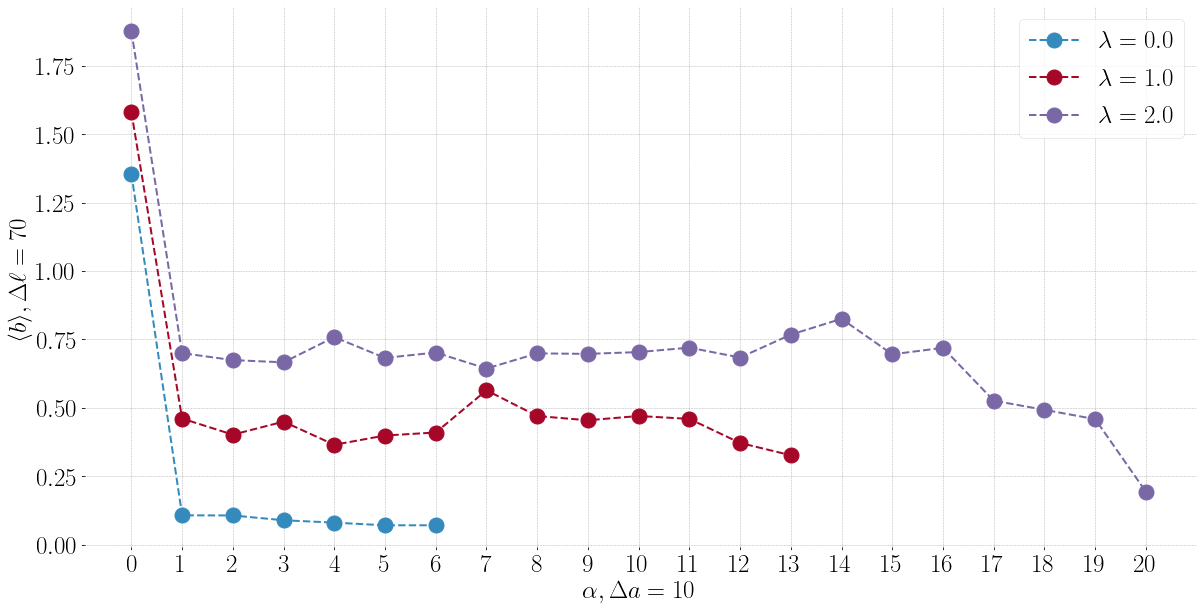

In [49]:
plt.ylabel(fr"$\langle b \rangle, \Delta \ell = 70$")
plt.xlabel(r"$\alpha, \Delta a = 10$")
plt.xticks(range(21))
for lamb in bplotnc['all'].keys():
    plt.plot(bplotnc['all'][int(lamb)].index, bplotnc['all'][int(lamb)]['alpha'], marker="o", markersize=15, ls="--", c=colors[int(lamb)], label=fr'$\lambda = {lamb}$')
plt.legend()

In [50]:
def get_plateau(series, allowed=0.5):
    x = list(series.index)
    mid = int(len(x) / 2)
    xlow, xhigh = x[mid - 1], x[mid + 1]
    newdf = series.loc[(series.index >= xlow) & (series.index <= xhigh)]
    grow = 1
    while (xlow != x[0]) and (xhigh != x[-1]):
        grow += 1
        newxmin, newxmax = x[mid - grow], x[mid + grow]
        tmp = series.loc[(series.index >= newxmin) & (series.index <= newxmax)]
        epsilon = max(tmp['alpha']) - min(tmp['alpha'])
        if epsilon >= allowed:
            break
        else:
            xlow, xhigh = newxmin, newxmax
            newdf = tmp
    return (xlow, xhigh, np.mean(newdf['alpha']))

In [51]:
# tmp = pd.DataFrame()
# for s in bplotnc['all'].keys():
#     df = bplotnc['all'][s]
#     df.columns = [f'l{int(s)}']
#     if len(tmp) == 0:
#         tmp = tmp.append(df)
#     else:
#         tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
# tmp.index.rename('alpha', inplace=True)
# tmp.fillna('nan', inplace=True)
# tmp.to_csv(f"../commpatterns/data/blamb_it.dat", header=True, sep="\t")

# Inset plot for Fig 1

In [52]:
with open('../itdata/fig1_F.pickle', 'rb') as handle:
    itinset = pickle.load(handle)
    handle.close()

In [53]:
t0 = dt.datetime.now()
bplots = {}
for Dl in range(40, 71, 5):
    dff = pc.get_f(callsnc[3]['all'], 'all', 10, Dl)
    dff.update(itinset[Dl])
    b = pc.get_b(dff, 'alpha')
    bplots[Dl] = pc.plot_g(b, 'alpha')
print(f'This block took {dt.datetime.now() - t0}')

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


This block took 0:03:15.593278


In [54]:
def get_plateau(series, allowed=0.5):
    x = list(series.index)
    mid = int(len(x) / 2)
    xlow, xhigh = x[mid - 1], x[mid + 1]
    newdf = series.loc[(series.index >= xlow) & (series.index <= xhigh)]
    grow = 1
    while (xlow != x[0]) and (xhigh != x[-1]):
        grow += 1
        newxmin, newxmax = x[mid - grow], x[mid + grow]
        tmp = series.loc[(series.index >= newxmin) & (series.index <= newxmax)]
        epsilon = max(tmp['alpha']) - min(tmp['alpha'])
        if epsilon >= allowed:
            break
        else:
            xlow, xhigh = newxmin, newxmax
            newdf = tmp
    return (xlow, xhigh, np.mean(newdf['alpha']))

In [55]:
plateaus = {}
for Dl in [50, 55, 60, 65, 70]:
    for lamb in bplots[Dl].keys():
        ell = int((lamb + 0.5) * Dl)
        if ell not in plateaus.keys():
            xmin, xmax, height = get_plateau(bplots[Dl][lamb])
            plateaus[ell] = height
platplot = pd.DataFrame.from_dict(plateaus, orient='index').sort_index()

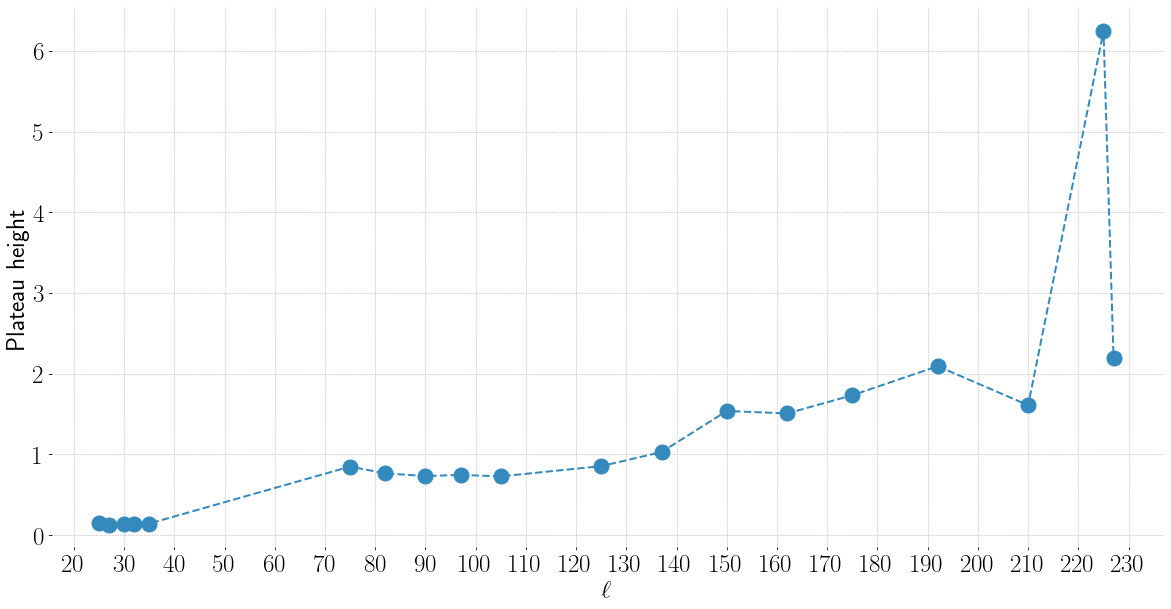

In [56]:
plt.xlabel(r"$\ell$")
plt.ylabel("Plateau height")
plt.xticks(range(0, 231, 10))
plt.plot(platplot.index, platplot[0], marker="o", markersize=15, ls="--")

In [57]:
# tmp = platplot.loc[platplot.index < 200]
# tmp.columns = ['y']
# tmp.index.rename('x', inplace=True)
# tmp.fillna('nan', inplace=True)
# tmp.to_csv("../commpatterns/data/plateau.dat", header=True, sep="\t")

In [58]:
print(f'Took {dt.datetime.now() - globalt0}')

Took 0:08:10.835570


# Trying some measurements

In [59]:
def get_survival(fresult, alphafixed=1, base=2, unbinned=False, prob=True):
    tmp = {}
    for ego in fresult.keys():
        for alter in fresult[ego].keys():
            df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alphafixed]
            if len(df) > 0:
                if unbinned:
                    F = sum(df['f'])
                else:
                    F = int(math.log(sum(df['f']), base))
                tmp[F] = tmp.get(F, {})
                lamb = df.iloc[0]['lambda']
                tmp[F][lamb] = tmp[F].get(lamb, 0) + 1
    tmp2 = {}
    for F in sorted(tmp.keys()):
        df = pd.DataFrame.from_dict(tmp[F], orient='index').sort_index()
        tmp2[F] = {}
        if prob:
            df['p'] = df[0].div(sum(df[0]))
        for lc in range(21):
            df2 = df.loc[df.index >= lc]
            if prob:
                tmp2[F][lc] = round(sum(df2['p']), 6)
            else:
                tmp2[F][lc] = sum(df2[0])
        tmp2[F] = pd.DataFrame.from_dict(tmp2[F], orient='index').sort_index()
    return tmp2

In [60]:
surv2 = get_survival(dff, prob=False)

In [61]:
test = {}
for ego in dff.keys():
    for alter in dff[ego].keys():
        data = dff[ego][alter].loc[dff[ego][alter]['alpha'] >= 1]
        if len(data) > 0:
            lamb = data.iloc[0]['lambda']
            test[lamb] = test.get(lamb, 0) + 1
test = pd.DataFrame.from_dict(test, orient='index').sort_index()
test['p'] = test[0] / sum(test[0])
null2 = {}
for lc in range(21):
    df = test.loc[test.index >= lc]
    null2[lc] = sum(df[0])
null2 = pd.DataFrame.from_dict(null2, orient='index').sort_index()

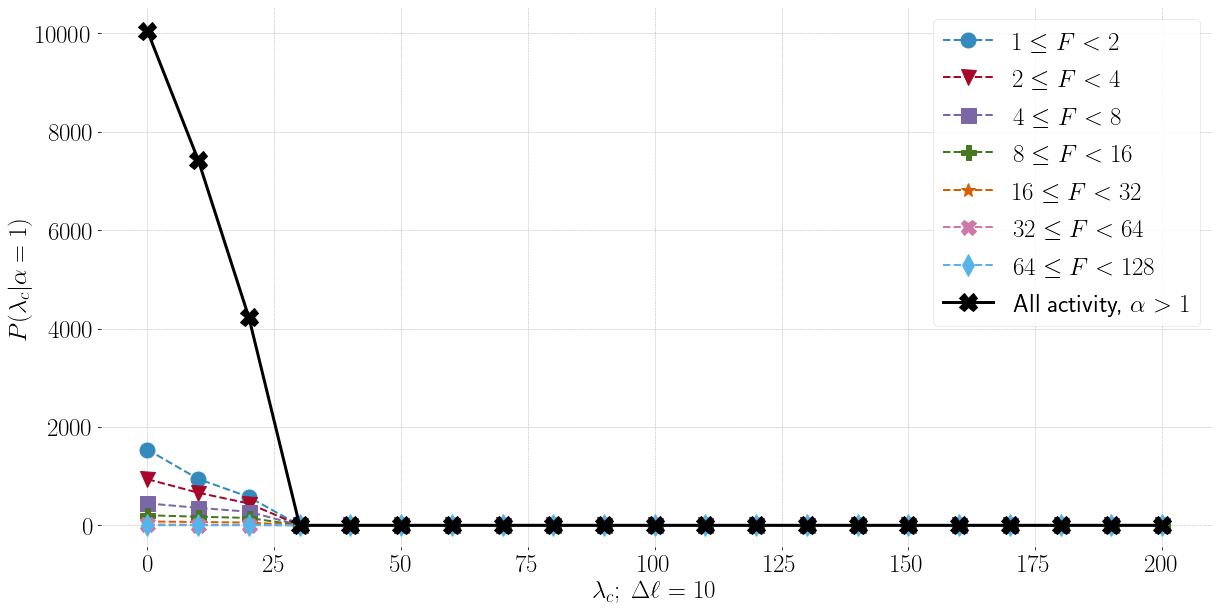

In [62]:
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(7)]

plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
m = 0
for f in range(7):
    plt.plot(surv2[f].index * 10, surv2[f][0], marker=markers[m], markersize=15, ls="--", label=fr'{series2[f]}')
    m += 1
plt.plot(null2.index * 10, null2[0], marker="X", markersize=18, ls="-", lw=3, c="black", label=r"All activity, $\alpha > 1$")
plt.legend()

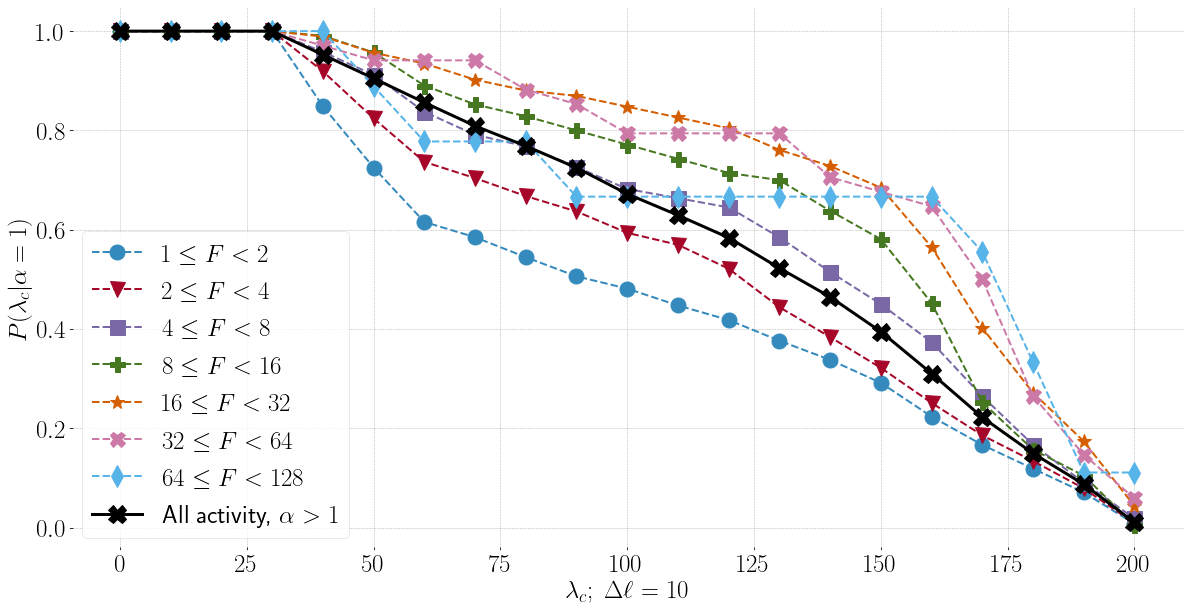

In [63]:
series2 = [f'${2**i} \leq F < {2**(i + 1)}$' for i in range(7)]

plt.xlabel(r'$\lambda_{c}; \; \Delta \ell  = 10$')
plt.ylabel(r'$P(\lambda_{c} | \alpha = 1)$')
m = 0
for f in range(7):
    plt.plot(survival[f].index * 10, survival[f][0], marker=markers[m], markersize=15, ls="--", label=fr'{series2[f]}')
    m += 1
plt.plot(null.index * 10, null[0], marker="X", markersize=18, ls="-", lw=3, c="black", label=r"All activity, $\alpha > 1$")
plt.legend()

In [64]:
import sklearn.metrics as sk
miit = {}
mi = {}
for F in range(7):
    miit[F] = sk.normalized_mutual_info_score([int(x*10**6) for x in survivalitnc['all'][F][0]], [int(x*10**6) for x in null[0]])
    mi[F] = sk.normalized_mutual_info_score([int(x*10**6) for x in survival[F][0]], [int(x*10**6) for x in null[0]])

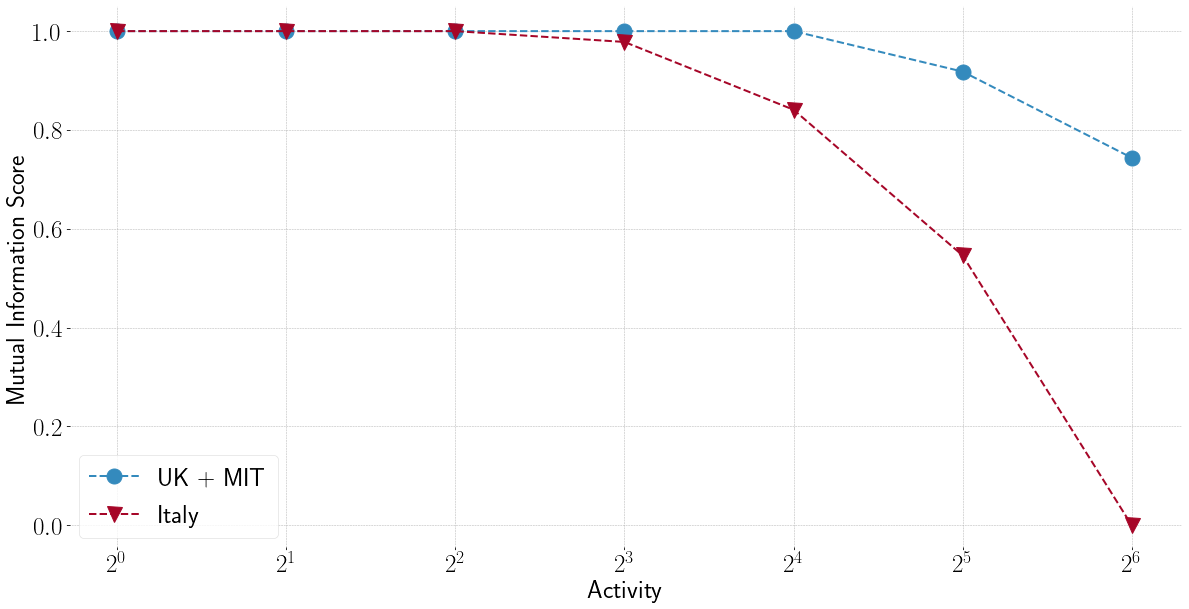

In [65]:
plt.xlabel("Activity")
plt.xticks([2**F for F in mi.keys()])
plt.ylabel("Mutual Information Score")
plt.xscale("log", base=2)
plt.plot([2**F for F in mi.keys()], mi.values(), marker=markers[0], markersize=15, ls="--", label="UK + MIT")
plt.plot([2**F for F in miit.keys()], miit.values(), marker=markers[1], markersize=15, ls="--", label="Italy")
plt.legend()

In [66]:
ksit = {}
ks = {}
for F in range(7):
    ksit[F] = stats.kstest(survivalitnc['all'][F][0], null[0])[1]
    ks[F] = stats.kstest(survival[F][0], null[0])[1]

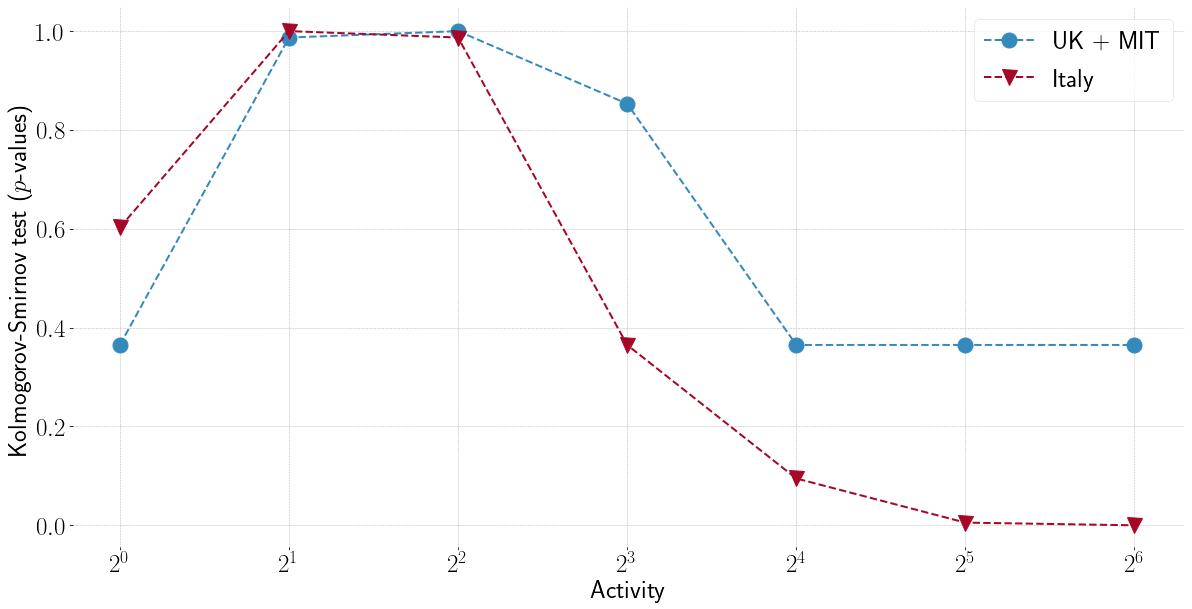

In [67]:
plt.xlabel("Activity")
plt.xticks([2**F for F in ks.keys()])
plt.ylabel("Kolmogorov-Smirnov test ($p$-values)")
plt.xscale("log", base=2)
plt.plot([2**F for F in ks.keys()], ks.values(), marker=markers[0], markersize=15, ls="--", label="UK + MIT")
plt.plot([2**F for F in ksit.keys()], ksit.values(), marker=markers[1], markersize=15, ls="--", label="Italy")
plt.legend()

In [68]:
P = {}
for ego in dff.keys():
    for alter in dff[ego].keys():
        df = dff[ego][alter]
        F = int(math.log(sum(df['f']), 2))
        P[F] = P.get(F, {})
        for i in df.index:
            lamb = df.at[i, 'lambda']
            P[F][lamb] = P[F].get(lamb, 0) + 1

In [69]:
aaa = {}
for k in P.keys():
    for kk in sorted(P[k].keys()):
        aaa[k] = pd.DataFrame.from_dict(P[k], orient='index').sort_index()

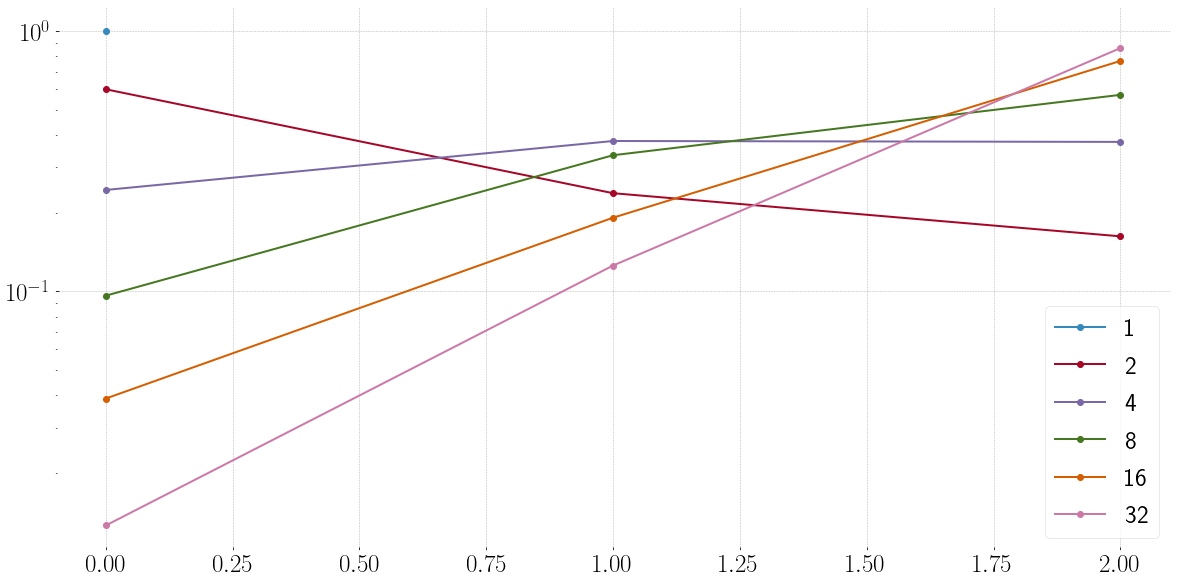

In [70]:
plt.yscale("log")
#plt.ylim(10**-2, 10**-1)
for act in range(6):
    plt.plot(aaa[act].index, aaa[act][0] / sum(aaa[act][0]), "o-", label=f'{2**act}')
plt.legend()

# I need probability distributions

Instead of survival curves

In [71]:
def get_survdist(fresult, alphafixed=1, base=2):
    tmp = {}
    for ego in fresult.keys():
        for alter in fresult[ego].keys():
            df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alphafixed]
            if len(df) > 0:
                F = int(math.log(sum(df['f']), base))
                tmp[F] = tmp.get(F, {})
                lamb = df.iloc[0]['lambda']
                tmp[F][lamb] = tmp[F].get(lamb, 0) + 1
    tmp2 = {}
    for F in sorted(tmp.keys()):
        df = pd.DataFrame.from_dict(tmp[F], orient='index').sort_index()
        df.columns = ['calls']
        df['p'] = df['calls'].div(sum(df['calls']))
        tmp2[F] = df
        
    return tmp2

In [72]:
dff = pc.get_f(callsnc[3]['all'], 'all', 30, 10)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


In [73]:
%time aaaa = get_survdist(dff)

CPU times: user 2.98 s, sys: 13.6 ms, total: 2.99 s
Wall time: 2.96 s


In [74]:
for i in aaaa.keys():
    print(sum(aaaa[i]['p']))

0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0
1.0
1.0
1.0
1.0


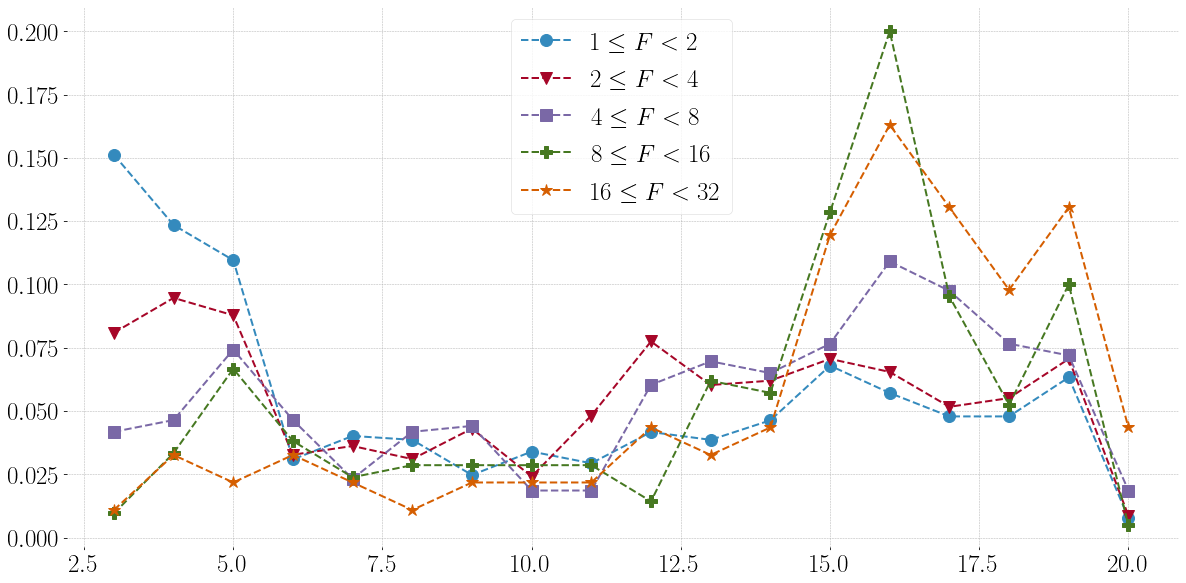

In [75]:
#plt.xticks(range(0, 201, 10))
for F in range(5):
    plt.plot(aaaa[F].index, aaaa[F]['p'], marker=markers[F], markersize=12, ls="--", label=series2[F])
plt.legend()

In [76]:
aaaa[0]

,calls,p
3,98,0.151235
4,80,0.123457
5,71,0.109568
6,20,0.030864
7,26,0.040123
8,25,0.038580
9,16,0.024691
10,22,0.033951
11,19,0.029321
12,27,0.041667


Now to obtain the joint probability of $\lambda$ and $F$

In [77]:
lamb_marg = {}
for l in range(21):
    if l < 3:
        lamb_marg[l] = 0
    else:
        for F in range(6):
            if l in aaaa[F].index:
                lamb_marg[l] = lamb_marg.get(l, 0) + aaaa[F].loc[l, 'calls']
lamb_marg = list(lamb_marg.values())

In [78]:
tsum = sum(lamb_marg)
for l in range(len(lamb_marg)):
    lamb_marg[l] = lamb_marg[l] / tsum

In [79]:
sum(lamb_marg)

0.9999999999999999

In [80]:
f_marg = []
for f in range(6):
    f_marg.append(sum(aaaa[f]['calls']))

In [81]:
tsum = sum(f_marg)
for F in range(len(f_marg)):
    f_marg[F] = f_marg[F] / tsum

In [82]:
sum(f_marg)

1.0

In [83]:
#sk.mutual_info_score(lamb_marg, f_marg, contingency=joint)

NameError: name 'joint' is not defined

In [84]:
joint = np.zeros((21, 6))
for l in range(3, 21):
    for F in range(6):
        if l in aaaa[F].index:
            joint[l][F] = aaaa[F].at[l, 'calls']

In [85]:
joinp = []
for i in range(21):
    for j in range(6):
        joinp.append(joint[i][j] / sum(sum(joint)))

In [86]:
lamb_marg

[0.0,
 0.0,
 0.0,
 0.08366733466933868,
 0.08316633266533066,
 0.08517034068136273,
 0.03507014028056112,
 0.033066132264529056,
 0.034569138276553106,
 0.03507014028056112,
 0.026052104208416832,
 0.03156312625250501,
 0.05260521042084168,
 0.05460921843687375,
 0.05561122244488978,
 0.07865731462925851,
 0.09218436873747494,
 0.0716432865731463,
 0.06012024048096192,
 0.0746492985971944,
 0.012525050100200401]

In [87]:
stats.entropy(lamb_marg) + stats.entropy(f_marg) - stats.entropy(joinp)

0.07221561728399095

In [88]:
aaa = [1,2,3,4,5,6,7]
bbb = [1,2,3,4,5,6,7]

In [89]:
sk.mutual_info_score(aaa, bbb)

1.945910149055313

In [90]:
bbbb = get_survdist(dffitnc['all'])

In [91]:
it_joint = np.zeros((21, 6))
for l in range(3, 21):
    for F in range(6):
        if l in bbbb[F].index:
            it_joint[l][F] = bbbb[F].at[l, 'calls']

In [92]:
it_joinp = []
for i in range(21):
    for j in range(6):
        it_joinp.append(it_joint[i][j] / sum(sum(it_joint)))

In [93]:
joint2 = []
for i in range(21):
    for j in range(6):
        joint2.append(joint[i][j])

it_joint2 = []
for i in range(21):
    for j in range(6):
        it_joint2.append(it_joint[i][j])

In [94]:
sk.mutual_info_score(joint2, it_joint2)

2.4111552614500975

In [95]:
egoalter = pd.DataFrame()
idx = 0
for ego in dff.keys():
    for alter in dff[ego].keys():
        df = dff[ego][alter].loc[dff[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            egoalter.at[idx, 'ego'] = ego
            egoalter.at[idx, 'alter'] = alter
            egoalter.at[idx, 'F'] = sum(df['f'])
            egoalter.at[idx, 'lambda'] = lives['all'][ego][alter]['ell']
            idx += 1

In [96]:
egoalter.head()

,ego,alter,F,lambda
0,fa10-01-19,17767c7c7cb7989aed95e056ee962e080d766bf3,1.0,135.0
1,fa10-01-19,255e12b1d5ca8ba0d42571d825e3216bff3b47d,13.0,161.0
2,fa10-01-19,28f56311bc890088ab948700d18bd8402ca565a,3.0,136.0
3,fa10-01-19,3b0bed238b889f3234c2a75f56656db43ecc7e6,9.0,143.0
4,fa10-01-19,90df4f52ae4ceeb11aecf213e34ad501f8a143b7,18.0,175.0


In [97]:
sk.mutual_info_score(egoalter['F'], egoalter['lambda'])

0.7379996044563527

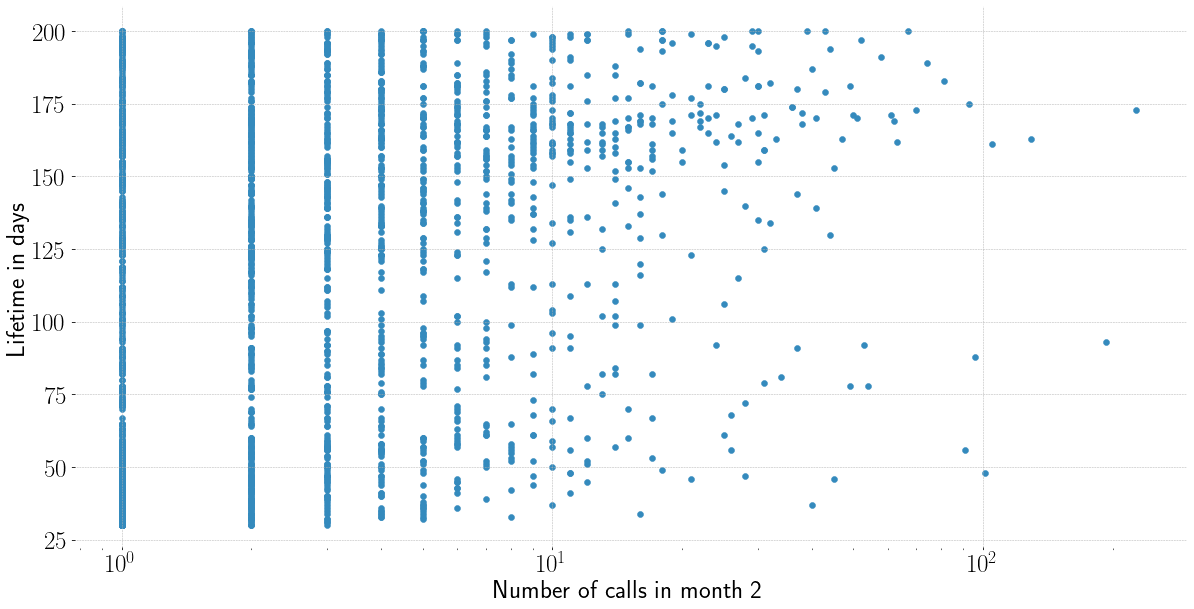

In [98]:
plt.xlabel("Number of calls in month 2")
plt.ylabel("Lifetime in days")
plt.xscale("log")
plt.scatter(egoalter['F'], egoalter['lambda'])

# TESTING AREA

In [99]:
df = callsoc[3]['all']
df.loc[df['aclock'] == 200]

,ego,alter,time,uclock,aclock
63037,uk2C07814508939,C07950483877,2008-06-19 22:05:00,292,200
63038,uk2C07814508939,C07950483877,2008-06-19 22:11:00,292,200
63039,uk2C07814508939,C07950483877,2008-06-19 23:10:00,292,200
63040,uk2C07814508939,C07950483877,2008-06-20 00:15:00,292,200
65477,uk2C07817280467,C07864909708,2008-05-23 19:13:00,265,200
66069,uk2C07890818114,C07816387272,2008-05-03 17:37:00,245,200
66070,uk2C07890818114,C07816387272,2008-05-04 04:57:00,245,200
66071,uk2C07890818114,C07816387272,2008-05-04 06:11:00,245,200


In [100]:
df = callsnc[3]['all']
a = pc.get_f(df, 'all', 30, 10)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


In [101]:
df.loc[(df['ego'] == 'uk1C07896537661') & (df['alter'] == 'C01142735983')]

,ego,alter,time,uclock,aclock
57399,uk1C07896537661,C01142735983,2007-05-21 12:05:00,76,0
57400,uk1C07896537661,C01142735983,2007-05-21 14:14:00,77,1
57401,uk1C07896537661,C01142735983,2007-06-07 15:44:00,94,18
57402,uk1C07896537661,C01142735983,2007-06-22 14:20:00,109,33
57403,uk1C07896537661,C01142735983,2007-08-10 10:00:00,157,81
57404,uk1C07896537661,C01142735983,2007-09-24 10:52:00,202,126


In [102]:
a['uk1C07896537661']['C01142735983']

,lambda,alpha,f
0,12,0,3
1,12,1,1
2,12,2,1
3,12,4,1


In [103]:
test = {}
for ego in a.keys():
    for alter in a[ego].keys():
        df2 = a[ego][alter].loc[a[ego][alter]['alpha'] == 1]
        if len(df2) > 0:
            F = int(np.log2(sum(df2['f'])))
            test[F] = test.get(F, {})
            lamb = df2.iloc[0]['lambda']
            test[F][lamb] = test[F].get(lamb, 0) + 1
            
for F in test.keys():
    test[F] = pd.DataFrame.from_dict(test[F], orient='index').sort_index()

In [104]:
sorted(test.keys())

[0, 1, 2, 3, 4, 5, 6, 7]

In [105]:
b = {}
for F in test.keys():
    b[F] = {}
    df = test[F]
    df['p'] = df[0].div(sum(df[0]))
    for lc in range(21):
        df2 = df.loc[df.index >= lc]
        b[F][lc] = sum(df2['p'])
    b[F] = pd.DataFrame.from_dict(b[F], orient='index').sort_index()

In [106]:
test.keys()

dict_keys([0, 3, 1, 4, 2, 5, 6, 7])

In [107]:
math.log(9, 3)

2.0